#  <font color='Blue'>Autism Spectrum Disorder in Adults</font> 

<br> Why is this problem important to look at? <br> <br> Over the next decade, an estimated 707,000 to 1,116,000 teens (70,700 to 111,600 each year) will enter adulthood and age out of school based autism services [Source:https://www.autismspeaks.org/autism-statistics] <br> The life of adults with autism is not easy and seeking diagnosis could be challenging for them as <br>(1) Firstly, people who did not receive a diagnosis in their younger years may have milder symptoms, which can be more difficult for a doctor to recognize <br>(2) Secondly, if people have been living with ASD for some time, they may be better at disguising or managing the signs and symptoms.<br> So, individuals may wish to begin with a self-assessment test for adults. While these tests cannot confirm a diagnosis, they are a good starting point and provide material to discuss with a healthcare professional.[Source:https://www.medicalnewstoday.com/articles/326841#diagnosis] 

Our problem precisely focuses on just that. Having a screening test would help individuals decide if they would want to be diagnosed and for healthcare professionals, it would reduce the cases attended and the costs involved.

# <font color='Blue'>Summary</font>

This is an attempt to understand the data set on Autistic Spectrum Disorder in Adults.<br> I have discussed the following in the below sections.<br>

1.Data Pre-processing<br>
2.EDA<br>
3.Split the set into predictor set and label<br>
4.Split the set into train and test set<br>
5.Filling missing values<br>
6.Class imbalance - upsampling<br>
7.Feature Selection<br>
8.Modeling<br>
9.Observations<br>

# Import libraries

In [1]:
from pandas import Series, DataFrame
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score,f1_score,recall_score,confusion_matrix,auc,classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
%pylab inline
import re

Populating the interactive namespace from numpy and matplotlib


Let's read in the data.

In [2]:
df=pd.read_csv("Autism-Adult-Data.csv")

In [4]:
df.head(5)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,Age,Gender,Ethnicity,Jundice,Family,Country_of_res,Used_app_before,Age_desc,Relation,ASD
0,1.0,1.0,1.0,1.0,0,0.0,1.0,1.0,0.0,0.0,26.0,f,White-European,no,no,'United States',no,'18 and more',Self,NO
1,1.0,1.0,0.0,1.0,0,0.0,0.0,1.0,0.0,1.0,24.0,m,Latino,no,yes,Brazil,no,'18 and more',Self,NO
2,1.0,1.0,0.0,1.0,1,0.0,1.0,1.0,1.0,1.0,27.0,m,Latino,yes,yes,Spain,no,'18 and more',Parent,YES
3,1.0,1.0,0.0,1.0,0,0.0,1.0,1.0,0.0,1.0,35.0,f,White-European,no,yes,'United States',no,'18 and more',Self,NO
4,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,40.0,f,NaN,no,no,Egypt,no,'18 and more',NaN,NO


In [5]:
df.shape

(704, 20)

This dataset contains responses from 704 people and their stats including individual data on Age,country of residence,did they have jaudince or not, family, usage of app before and responses to 10 behavioural questions(ananomyzed). Let's clean the data a bit and check for missing values.<br> <br>
The features are all categorical with only Age being a numerical feature. Also, the column Age_desc seems to have only one category of '18 or more'. No variation in data in the column indicates that it would be of no use in predicting the class.

In [6]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'Age', 'Gender', 'Ethnicity', 'Jundice', 'Family', 'Country_of_res', 'Used_app_before', 'Age_desc', 'Relation', 'ASD'], dtype='object')

In [7]:
#Check for duplicates
df1=df.drop_duplicates()
df1.shape

(701, 20)

After dropping the duplicates, we now have 701  responses with 20 features.

# <font color='Blue'>Data Pre-processing - Missing values and Outliers</font>

In [8]:
#% of missing values in the features
(df.isna().sum()/df.shape[0])*100

A1_Score            0.568182
A2_Score            0.426136
A3_Score            0.426136
A4_Score            0.426136
A5_Score            0.000000
A6_Score            0.284091
A7_Score            0.710227
A8_Score            0.142045
A9_Score            0.426136
A10_Score           0.142045
Age                 0.852273
Gender              0.426136
Ethnicity          14.204545
Jundice             0.568182
Family              0.710227
Country_of_res      0.568182
Used_app_before     0.426136
Age_desc            0.568182
Relation           13.778409
ASD                 0.000000
dtype: float64

Some features have high  number of missing values. Now, it is important to check if there is a pattern. Here, it seems to be random. So, we need to think of a way to treat them.<br> <br> As we saw earlier, Age being a numerical feature, let's look at the summary of it.

In [9]:
df['Age'].describe()

count    698.000000
mean      29.710602
std       16.542781
min       17.000000
25%       21.000000
50%       27.000000
75%       35.000000
max      383.000000
Name: Age, dtype: float64

The distibution seems to be concentrated around a younger age of 29 and the distibution is balanced. However, the max value is rather unrealistic. 383 years, that can't be true!.

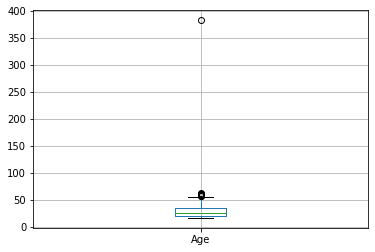

In [10]:
 df.boxplot(column=['Age'])

Looking at the box plot of  Age, it is seen that this point seems to be a clear outlier. So, let's drop it for now after checking for the class it belongs to. Further, let's bin the age to form age buckets. While we could lose some information while binning, it would help us in visualization and give us a clearer picture of its relation.

In [11]:
df=df.drop(df[df['Age']==383].index,axis=0)
df['age_bucket']='Missing'
df['age_bucket']=np.where(df['Age']<18,'less than 18',
                 np.where((df['Age']>=18)&(df['Age']<25),'18-24',
                 np.where((df['Age']>=25)&(df['Age']<40),'25-39',
                 np.where((df['Age']>=40)&(df['Age']<55),'40-54',
                 np.where((df['Age']>=55),'greater than 55',
                 df['age_bucket'])))))
df=df.drop(['Age_desc','Age'],axis=1)

In [12]:
df['Ethnicity']=np.where(df['Ethnicity']=='others','Others',df['Ethnicity'])

# <font color='Blue'>EDA</font>

# Distibution of features

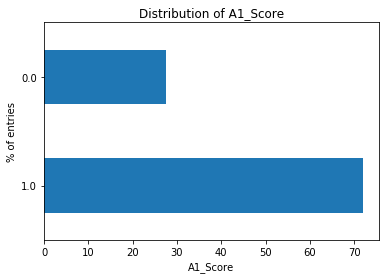

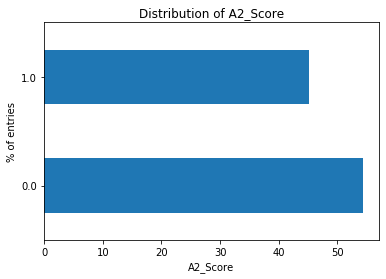

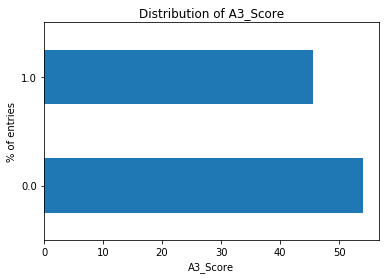

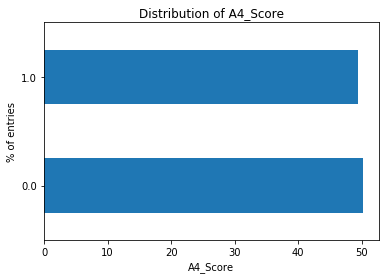

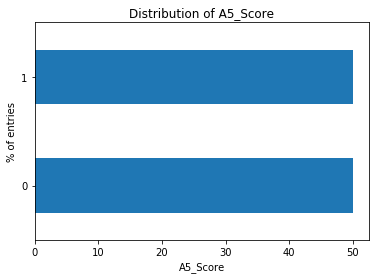

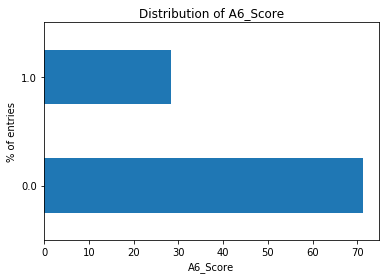

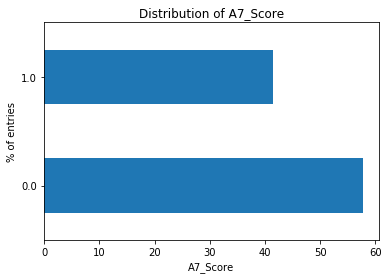

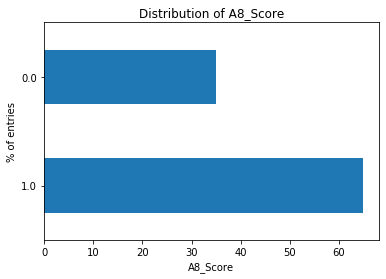

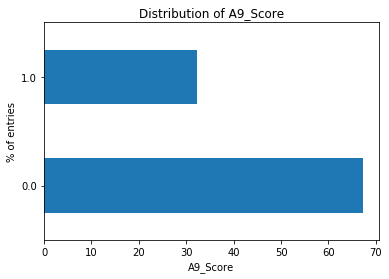

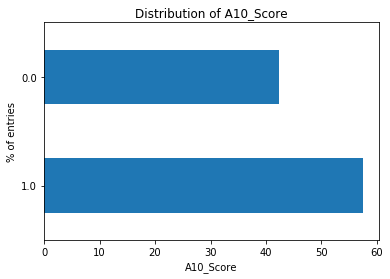

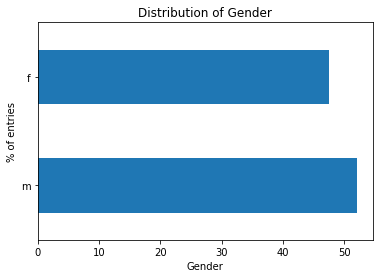

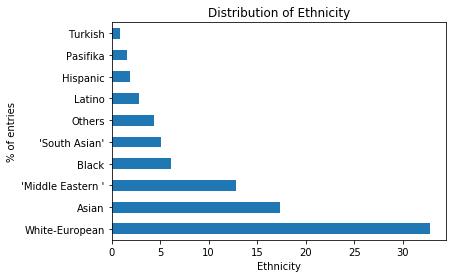

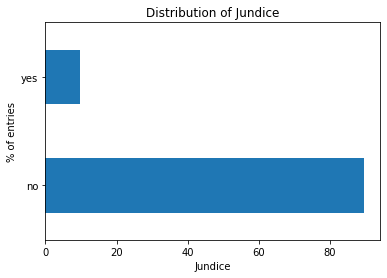

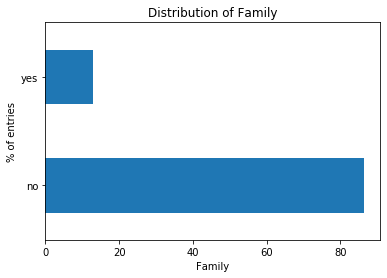

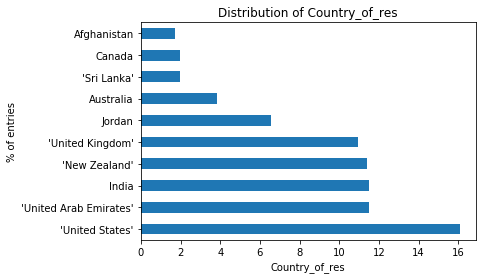

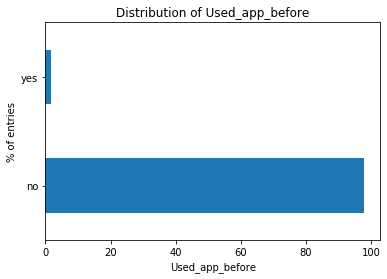

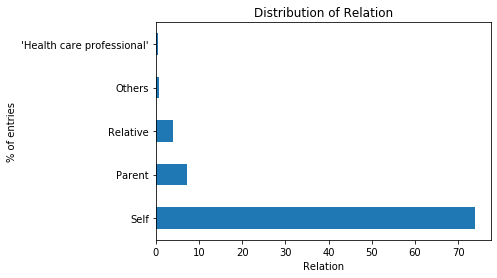

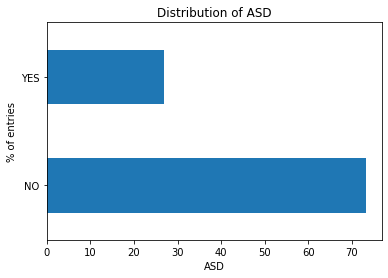

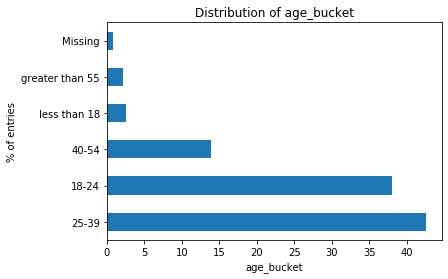

In [13]:
 def plot_dist(column):
    x=round((df.groupby(column)['ASD'].count()/df.shape[0])*100,2).sort_values(ascending=False).nlargest(n=10)
    x.plot(kind='barh')
    xlabel(column)
    ylabel('% of entries')
    plt.title('Distribution of '+ column)
    
for i in range(0,len(df.columns)):
    plot_dist(df.columns[i])
    plt.show()

From the responses to the test, we see that A1,A8 and A10 have around 70%,65%,55% of respondents pick option 1 to the question. Q4 and 5 have 50% of respondents pick option 1 and the other half pick 0. The other questions have a higher proportion of people picking 0 for the answer.<br> <br> Looking at the individual questions, the sample seems to have a good mix of people. 55% of respondents are male. White-European,Asian,Middle Eastern seem to be the dominant ethinicities in the set.This ties up with United States, UAE and India being the dominant country of residence.When looking at age distribution, 45% of respondents are from (25-39) years and less than 5% of people fall into the buckets 'less  than 18' and 'greater than 55'.<br> <br>As for previous history, almost 90% of them were not born with jaundice,do not have family member with PDD and close to 98% of them have not used a screening app before.<br> <br> The most interesting point to be noted is that about 70% of people in the sample has completed the test by themselves. So, the answers to the questions 1-10 might have response bias.<br> <br>The target variable here, whether the person has ASD, we see that almost 70% of them do not have ASD and around 30% have ASD.

# Effect on target

Let's now see how are the features affecting the target variable.

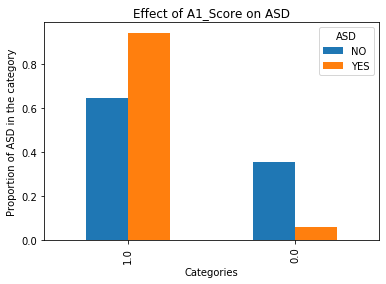

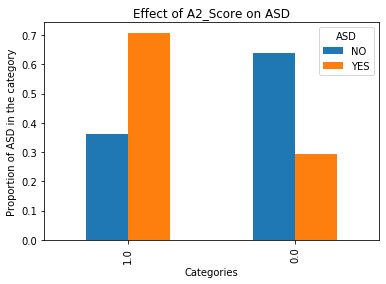

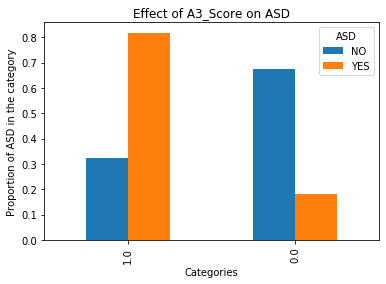

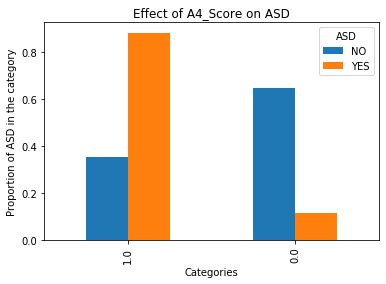

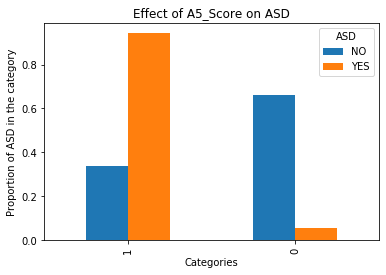

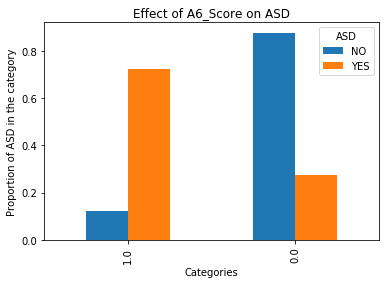

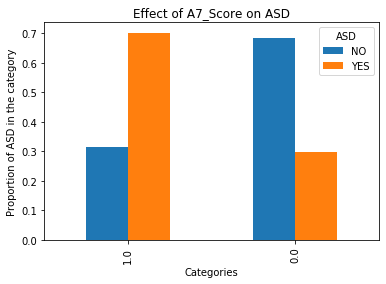

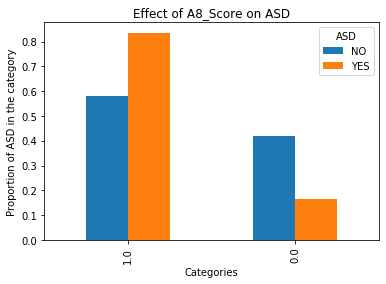

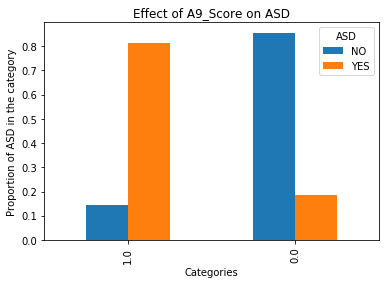

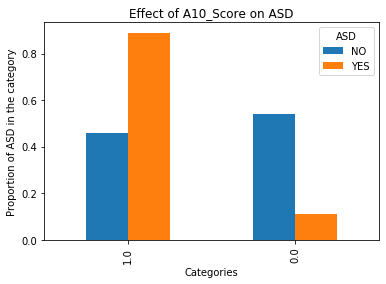

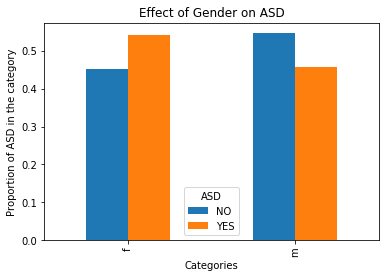

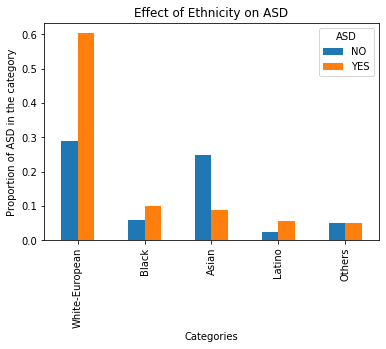

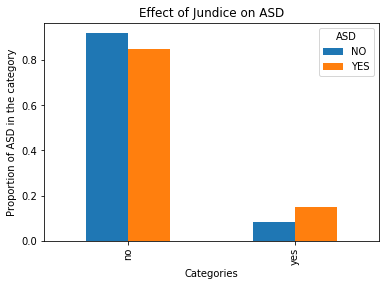

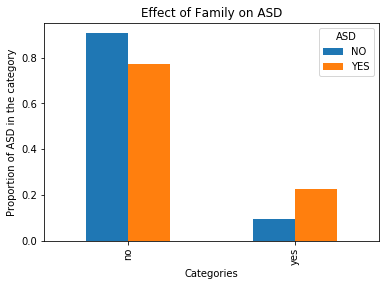

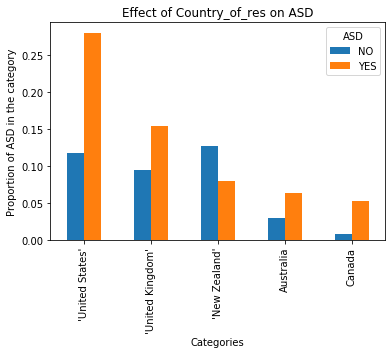

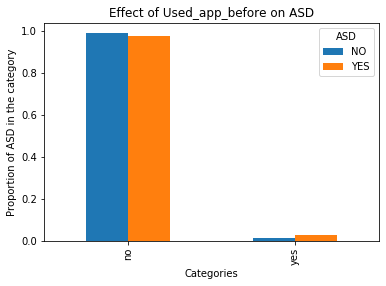

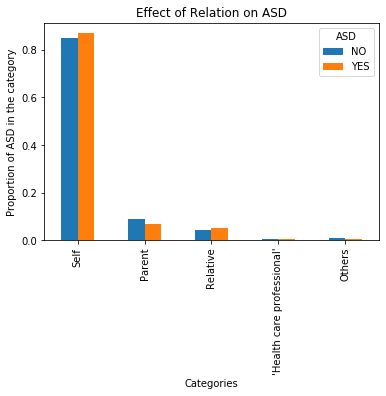

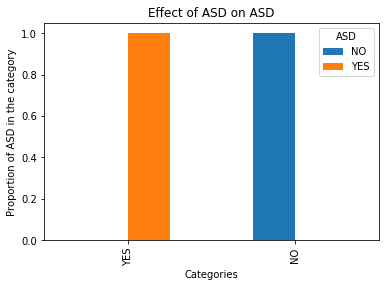

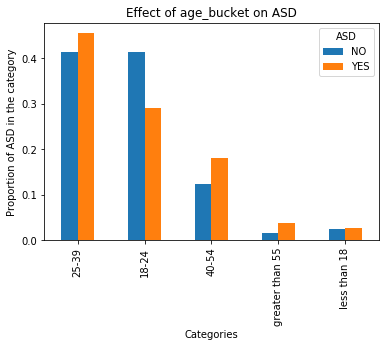

In [14]:
def plot_ASD(data):
    x = pd.crosstab(data,df['ASD'])
    total_asd = x.apply(sum)
    x_prop = (x/total_asd).sort_values(by='YES',ascending=False).nlargest(n=5,columns='YES').plot(kind='bar')
    xlabel('Categories')
    ylabel('Proportion of ASD in the category')
    plt.title('Effect of ' + df.columns[i] + ' on ASD')

for i in range(0,len(df.columns)):
    plot_ASD(df[df.columns[i]])
    plt.show()

Observations<br> <br>
All questions 1-10 when answered 1 has a higher proportion of people having ASD. So, these questions seem to be strong indicators to understand if a person has ASD. This intuitively makes sense as well since these questions were probably coined with that objective in mind.<br> <br> Next, ethnicity and country of residence seems to be good indicators of the target as there is a huge difference between the two classes. However, these two varaibles could be correlated if we assume that most people of a particular ethnicity reside in some countries.<br> <br> The other predictors of Age bucket, gender, used app or having jaundice has a slight difference in the proportion of ASD vs non-ASD cases in their categories, but is not a huge difference. It would be interesting to see how this changes when we see the effect in combination of all variables.

# Split into predictor set and label

With the goal in mind and treating this as a classification problem, let's split the predictor set and the target variable. So, we set the target as column:<br>

In [15]:
X = df.loc[:, df.columns != 'ASD'] #predictor set
y = df['ASD']  #target variable

#checking for proportion of the classes in the label
y.value_counts()/df.shape[0]*100

NO     73.11522
YES    26.88478
Name: ASD, dtype: float64

The data set has 73% of respondents who do not have ASD and 26% who have ASD. The size of both the classes are not equal and that makes this an imbalanced dataset.The class of interest to us is ASD(class 1)

# Split into train and validation

Next we split into train and test set. Ideally, we would use it for validation and test set is really the future values. But in this case, since we do not have access to future points, I'm going to treat the validation set as the test set. This is really to help us test the goodness of fit of our model and check for underfitting/overfitting by the model.

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,\
                                               random_state=78,stratify=y)

In [17]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((492, 18), (211, 18), (492,), (211,))

Checking for proportion of ASD vs non-ASD in train and test labels.

In [18]:
round(y_train.value_counts()/y_train.shape[0]*100,2)

NO     73.17
YES    26.83
Name: ASD, dtype: float64

In [19]:
round(y_test.value_counts()/y_test.shape[0]*100,2)

NO     72.99
YES    27.01
Name: ASD, dtype: float64

The proportion of split has been retained in both train and test set.

# <font color='Blue'> Missing value Imputation</font>

Now that we have split the data set into train and test, let's impute the missing values in the two sets separately. This is done for train and test individually to avoid data leakage into the test set.

In [20]:
def impute(df):
    #filling the behavioural columsn with binary responses with their mode
    mode_cols=df.columns[(df.dtypes==float64) | (df.dtypes==int64)]
    for i in range(0,len(mode_cols)):
        df[mode_cols[i]]=df[mode_cols[i]].fillna(df[mode_cols[i]].mode()[0])
    #filling the individual detail columns with a category called Missing
    obj_cols=df.columns[(df.dtypes==object)]
    for i in range(0,len(obj_cols)):
        df[obj_cols[i]]=df[obj_cols[i]].fillna('Missing')
    return(df)

X_train=impute(X_train)
X_test=impute(X_test)

#  <font color='Blue'>Data Balancing</font>

To handle the class imbalance, let's upsample the train data,given the data size. This samples the minority class to the size of the majority class. We need to merge the X_train and y_train back again before upsampling.

In [21]:
merged_xy=X_train.merge(y_train,left_index=True,right_index=True)
not_ASD=merged_xy[merged_xy['ASD']=='NO']
ASD=merged_xy[merged_xy['ASD']=='YES']

#upsample
ASD_upsampled = resample(ASD,
                        replace = True, 
                        n_samples = len(not_ASD), # match majority n
                        random_state = 27) 

#train set
X_train = pd.concat([ASD_upsampled, not_ASD])

#split back into X and y
y_train=X_train['ASD']
X_train=X_train.drop('ASD',axis=1)

X_train.shape,y_train.shape

((720, 18), (720,))

We now have 720 responses with 18 features in the train set. Remember the features are all still categorical.

# <font color='Blue'>One hot encoding</font>

We now one hot encode the categorical variables and the would increase the number of features.

In [22]:
X_train['status']='train'
X_test['status']='test'
merged=pd.concat([X_train,X_test])

#get dummies
merged=pd.get_dummies(merged)

#split it back into train and test
X_train=merged[merged['status_train']==1]
X_test=merged[merged['status_test']==1]

#drop status column
X_train=X_train.drop(['status_train','status_test'],axis=1)
X_test=X_test.drop(['status_train','status_test'],axis=1)

#y column - change from binary character response to numerical [0,1]
y_train=y_train.replace(["YES","NO"],[1,0])
y_test=y_test.replace(["YES","NO"],[1,0])

In [23]:
y_train.to_csv('y_train.csv')

In [23]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((720, 113), (211, 113), (720,), (211,))

We now have 114 features. This is still a relatively smaller data set. Still, getting the best features to use in the model would be helpful in terms of reducing the size of the data further and thus processing time.

# <font color='Blue'>RFECV - Backward feature elimination</font>

We use the Recursive Feature Elimination with cross validation to select the best features by eliminating one feature in every iteration. Since we use the Random Forest model to do this, the worst feature is the one that has the lowest feature importance. This feature is then eliminated and iterated again.

In [24]:
def rfecv(x,y):
    model = RandomForestClassifier(n_estimators=100,random_state=22)
    rfecv = RFECV(estimator=model, step=1, cv=5, scoring='f1')
    selector = rfecv.fit(x,y)
    print("Optimal number of features : %d" % selector.n_features_)
    support=selector.support_
    rank=selector.ranking_
    feature_rank=pd.DataFrame({'Feature':X_train.columns,'Rank':rank})
    feature_selected=feature_rank[feature_rank['Rank']==1]['Feature']
    feature_selected=feature_selected.tolist()
    print(feature_selected)
    return(feature_selected)

In [25]:
feature_selected=rfecv(X_train,y_train)

Optimal number of features : 19
['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'Gender_m', "Ethnicity_'Middle Eastern '", 'Ethnicity_Asian', 'Ethnicity_White-European', "Country_of_res_'New Zealand'", "Country_of_res_'United States'", 'Relation_Self', 'age_bucket_18-24', 'age_bucket_25-39']


# Train and test sets after feature selection

Finally, we now have our train and test set with the selected features that we would use in modeling further.

In [26]:
train=X_train[feature_selected]
test=X_test[feature_selected]

train.shape,test.shape,y_train.shape,y_test.shape

((720, 19), (211, 19), (720,), (211,))

In [27]:
# train.to_csv('Train_PS.csv')
# test.to_csv('Test_PS.csv')

# <font color='Blue'>Modelling</font>

Choice of model: This being a binary classification model, our goal is to predict the probability of a class occuring. I choose to try logistic regression and Random Forest models to get the predictions.<br> <br> (1) Logistic Regression requires there to be little or no multi collinearity among the independent variables to perform better. Also, it assumes linearity of independent variables and log odds.We chose to go with this model as the equation is interpretable and the coefficients gives us the direction of influence on the dependent variable.<br> <br> (2) Random Forest, a tree-based model that uses bagging and feature randomness to create an uncorrelated forest of trees was chosen to improve the accuracy of our predictions. Also,to leverage the feature importance feature of this model.

Choice of metric : Since this is an imbalanced data set, accuracy would not be a good metric to assess the performance of the model as even if we predict the majority class label for the entire set, we would be correct 70% of the time.<br> <br> We use Recall (calculated from components of the confusion matrix) as parameter to evaluate how well the model is doing.

Recall is defined as, TP/(TP+FN)

where,

· True Positive(TP) is when the model correctly predicts the actual positive class

· False Negative(FN) is an outcome when the model misclassifies the positive class.

Recall is high when the true positive is high and false negative is low.

For our problem, we want the recall to be high. We want to classify having ASD as positive class and not miss out on classifying these correctly. The reason being, cost associated with missing a person who has ASD is much higher than missing a person who does not have ASD.

# Logistic Regression

In [28]:
def predict(x_tr,x_te,y_tr,y_te,model,threshold):
    model.fit(x_tr,y_tr)
    y_pred_tr=model.predict_proba(x_tr)
    y_pred_te=model.predict_proba(x_te)
    
    #train
    y_predicted_tr = np.where(y_pred_tr[:,1]>threshold,1,0)   

    #test
    y_predicted_te = np.where(y_pred_te[:,1]>threshold,1,0)
    
    #confusion matrix
    con_05 = confusion_matrix(y_te,y_predicted_te)
    print(pd.DataFrame(con_05, columns=['pred(neg)', 'pred(pos)']))
    
    #normal model
    print("Classification report for classifier-train")
    print("AUROC: ", roc_auc_score(y_tr, y_pred_tr[:,1]))
    print()
    print(classification_report(y_tr, y_predicted_tr))

    print("Classification report for classifier-test")
    print("AUROC: ", roc_auc_score(y_te, y_pred_te[:,1]))
    print()
    print(classification_report(y_te, y_predicted_te))

    return(model)

In [29]:
result_lr=predict(x_tr=train,x_te=test,y_tr=y_train,y_te=y_test,model=LogisticRegression(random_state=42),threshold=0.48)

   pred(neg)  pred(pos)
0        142         12
1          0         57
Classification report for classifier-train
AUROC:  0.9983333333333334

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       360
           1       0.95      1.00      0.97       360

    accuracy                           0.97       720
   macro avg       0.97      0.97      0.97       720
weighted avg       0.97      0.97      0.97       720

Classification report for classifier-test
AUROC:  0.9979494190020506

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       154
           1       0.83      1.00      0.90        57

    accuracy                           0.94       211
   macro avg       0.91      0.96      0.93       211
weighted avg       0.95      0.94      0.94       211



The confusion matrix shows that we have False negatives of 0 and False positive of 12, which means our model is getting hold of everyone who has ASD correctly.

In [30]:
print("The intercept is",result_lr.intercept_)
print("The coefficients are")

weights_f = Series(result_lr.coef_[0],
                 index=train.columns.values)
weights_f2 = DataFrame(dict(weights = weights_f, weights_abs = weights_f.abs()))
weights_f2 = weights_f2.sort_values(by='weights_abs',ascending=False)
weights_f2 = weights_f2.reset_index().rename(columns={'index': 'Features'})
weights_f2

The intercept is [-7.30855283]
The coefficients are


,Features,weights,weights_abs
0,A5_Score,2.013766,2.013766
1,A9_Score,1.862506,1.862506
2,A6_Score,1.688487,1.688487
3,A7_Score,1.558133,1.558133
4,A4_Score,1.368707,1.368707
5,A10_Score,1.166306,1.166306
6,A3_Score,1.152398,1.152398
7,A2_Score,1.143020,1.143020
8,A8_Score,1.117146,1.117146
9,A1_Score,0.923320,0.923320


The coefficients show that all the questions asked are important indicators of whether a person has ASD or not. The coefficients are all positive indicating that answering Yes to this question increases the probability of the person having ASD. The most important being A5_Score,A6_Score and A9_Score. <br> <br>Some of the details of the individual also seems to have on effect on the probability. Male reduces the chance of having ASD and country of residence increases the probabaility. Given that, we are finding if a person should be screened further or not for ASD, it should ideally be done to everyone irrespective of their ethnicity, gender,etc. So, it is worthwhile to think whether we could drop these variables while building the model.

# Random Forest

In [31]:
result_rf=predict(x_tr=train,x_te=test,y_tr=y_train,y_te=y_test,model=RandomForestClassifier(random_state=35),threshold=0.48)

   pred(neg)  pred(pos)
0        149          5
1          8         49
Classification report for classifier-train
AUROC:  1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       360
           1       1.00      1.00      1.00       360

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720

Classification report for classifier-test
AUROC:  0.9808612440191388

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       154
           1       0.91      0.86      0.88        57

    accuracy                           0.94       211
   macro avg       0.93      0.91      0.92       211
weighted avg       0.94      0.94      0.94       211



Tuning the model:

In [32]:
# Number of trees in random forest
n_estimators = [20,50,100]
# Maximum number of levels in tree
max_depth = [5,10,15]
# Minimum number of samples required to split a node
min_samples_split = [5,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Method of evalutaion
criterion = ['gini','entropy']

tuned_parameters = [{'n_estimators':n_estimators,
                     'criterion': criterion,
                     'max_depth':max_depth,
                     'min_samples_split':min_samples_split,
                     'min_samples_leaf':min_samples_leaf,
                     'bootstrap':bootstrap}]
clf1 = GridSearchCV(RandomForestClassifier(random_state=35), tuned_parameters,cv=3)
clf1.fit(train, y_train)
print(clf1.best_params_)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


In [33]:
result_rf_tuned=predict(x_tr=train,x_te=test,y_tr=y_train,y_te=y_test,
                        model=RandomForestClassifier(random_state=35,bootstrap=False,
                        criterion='entropy',max_depth=10,min_samples_leaf=2,
                        min_samples_split=5,n_estimators=50),threshold=0.4)

   pred(neg)  pred(pos)
0        144         10
1          3         54
Classification report for classifier-train
AUROC:  1.0

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       360
           1       0.99      1.00      1.00       360

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720

Classification report for classifier-test
AUROC:  0.9899749373433584

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       154
           1       0.84      0.95      0.89        57

    accuracy                           0.94       211
   macro avg       0.91      0.94      0.92       211
weighted avg       0.94      0.94      0.94       211



Text(0.5, 1.0, 'Faature importance')

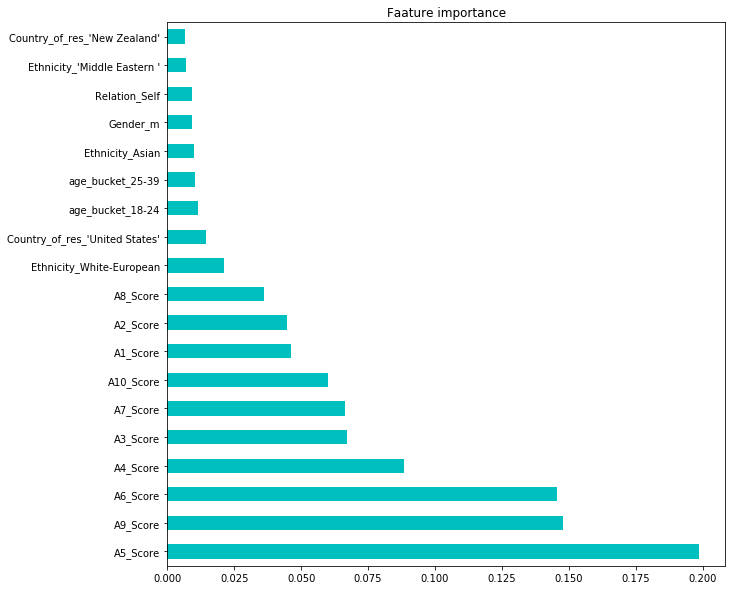

In [34]:
feat_importances = pd.Series(result_rf_tuned.feature_importances_, index=train.columns)
plt.figure(figsize=(10,10)) 
feat_importances.sort_values(ascending=False)[:20].plot(kind='barh',color='c')
plt.title('Faature importance')

# <font color='Blue'>Final Observations</font>

The results of the models seem to line with our EDA as well.<br>1.The answers to the behavioural questions seems to have a strong effect on the probability of someone having ASD.<br>2.Bias based on results of the individual information in the model-check on that<br>3.Response bias of respondents to be kept in mind